In [260]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

In [261]:
from sqlalchemy import create_engine

# MySQL 데이터베이스 연결 정보
user = 'root'
password = '1234'
host = 'localhost'
database = 'trouver'

# SQLAlchemy 엔진 생성
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

In [262]:
import tensorflow as tf
from tensorflow import keras
path = './ml-1m'

# Dataset
* rating.csv
* travel.csv
* users : 자체 DB 사용 예정 (MySQL)
> 출처 : BC카드 제주 관광객 소비패턴 변화 분석, 
> visitJEJU 기반 데이터 수집

In [263]:
#여행지 데이터프레임
def load_travels():
    col_name = ['contentsid','contentscd','regioncd_value','title','tag']
    travel_df = pd.read_csv(path+"/travel.csv",sep=';', header=0, engine='python', usecols=col_name)
    travel_df = travel_df.loc[(travel_df.contentscd=='c1'),col_name]

    # travel_df.head()
    return travel_df
load_travels()

,contentsid,contentscd,regioncd_value,title,tag
277,CNTS_000000000022068,c1,1,백제사,"실내,문화유적지,흐림,맑음,사계절,문화관광,역사유적,어트랙션"
313,CNTS_000000000022853,c1,3,대정면 4.3사건 위령비,"4.3,문화유적지"
320,CNTS_300000000015866,c1,2,아일랜드 플라워,"성산,동물원,먹이주기체험,이색체험,실내+실외,하,3시간이상"
359,CNTS_300000000016085,c1,1,오후 세시의 고양이,"휴식/힐링,오일파스텔,미술,예술,러닝홀리데이인제주,실내,1~2시간"
387,CNTS_000000000022855,c1,1,제주농업학교 옛터,"4.3,문화유적지"
...,...,...,...,...,...
4778,CONT_000000000500559,c1,1,제주세계자연유산센터,"흐림,가을,실내관광지,어트랙션,유네스코,무장애관광,공영관광지,공용주차장,현금결제,카..."
4779,CNTS_000000000020148,c1,3,수월봉,"부모,커플,혼자,친구,아이,맑음,가을,경관/포토,일몰,휴식/힐링,자연경관,포토스팟,..."
4781,CONT_000000000500267,c1,3,비양도,"섬속의섬,일몰,휴식/힐링,아이,맑음,여름,자연경관,어린이,언택트,유네스코,공용주차장..."
4782,CONT_000000000500685,c1,1,한라산국립공원,"산,걷기/등산,경관/포토,친구,사계절,자연경관,포토스팟,한라산,언택트,단풍,유네스코..."


In [264]:
#유저 평가 데이터프레임
def load_ratings() :
    col_name = ['user_idx','regioncd_value','pla_r_rate','pla_r_date']
    rating_df = pd.read_csv(path+"/rating.csv",sep=';', header=0, engine='python', names=col_name)
    # rating_df.head()
    return rating_df
# load_ratings()

임의로 사용자의 나이대에 따라 age_id 부여, 지역에 따라 id 부여.  
[참고 Notion Link 🔗](https://www.notion.so/jxxngxnt/44e0fcdeb8814a0ea9e12de162137637?pvs=4#cafa46a992c94de2a44dd8b375933ac6)  

In [265]:
# 서비스에 이용할 유저 데이터
def load_users() :

    #유저 데이터프레임
    query = '''
        SELECT 
            row_number () over(order by user_register) as user_idx,
            BIN_TO_UUID(user_id) as user_id,user_mbti, 
            user_gender,
            @age := FLOOR(DATEDIFF(NOW(), user_birth) / 365.25) AS age,
            CASE
                WHEN @age <=19 THEN 00
                WHEN @age BETWEEN 20 AND 29 THEN 20
                WHEN @age BETWEEN 30 AND 39 THEN 30
                WHEN @age BETWEEN 40 AND 49 THEN 40
                WHEN @age BETWEEN 50 AND 59 THEN 50
                WHEN @age >=60 THEN '60+'
            END AS user_age_group
        FROM user
        '''  # 실행할 SQL 쿼리

    users_df = pd.read_sql(query, engine)
    # print(users_df.head())
    return users_df

## preprocess datasets
### data 1. Ratings_df

In [266]:
ratings_df = load_ratings()
ratings_df.head()

,user_idx,regioncd_value,pla_r_rate,pla_r_date
0,1,4,5.8,1차년도
1,1,4,7.4,2차년도
2,1,2,6.6,1차년도
3,1,2,8.5,2차년도
4,1,1,7.6,1차년도


In [267]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_idx        80 non-null     int64  
 1   regioncd_value  80 non-null     int64  
 2   pla_r_rate      80 non-null     float64
 3   pla_r_date      80 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.6+ KB


In [268]:
ratings_df.drop("pla_r_date", axis=1, inplace=True)

In [269]:
ratings_df.head()

,user_idx,regioncd_value,pla_r_rate
0,1,4,5.8
1,1,4,7.4
2,1,2,6.6
3,1,2,8.5
4,1,1,7.6


<Axes: ylabel='Frequency'>

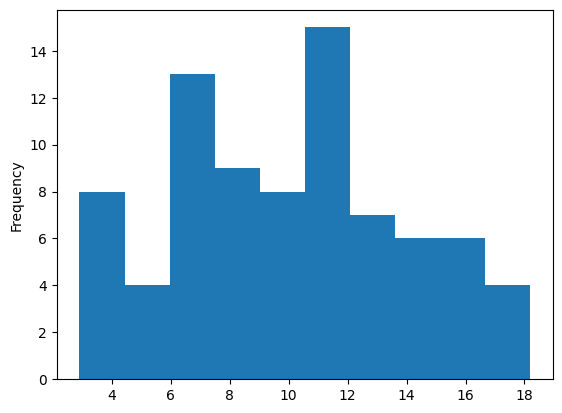

In [270]:
ratings_df.pla_r_rate.plot.hist()

### data 2. travels_df

In [271]:
travels_df = load_travels()
travels_df.head()

,contentsid,contentscd,regioncd_value,title,tag
277,CNTS_000000000022068,c1,1,백제사,"실내,문화유적지,흐림,맑음,사계절,문화관광,역사유적,어트랙션"
313,CNTS_000000000022853,c1,3,대정면 4.3사건 위령비,"4.3,문화유적지"
320,CNTS_300000000015866,c1,2,아일랜드 플라워,"성산,동물원,먹이주기체험,이색체험,실내+실외,하,3시간이상"
359,CNTS_300000000016085,c1,1,오후 세시의 고양이,"휴식/힐링,오일파스텔,미술,예술,러닝홀리데이인제주,실내,1~2시간"
387,CNTS_000000000022855,c1,1,제주농업학교 옛터,"4.3,문화유적지"


In [272]:
travels_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1287 entries, 277 to 4783
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   contentsid      1287 non-null   object
 1   contentscd      1287 non-null   object
 2   regioncd_value  1287 non-null   int64 
 3   title           1287 non-null   object
 4   tag             1287 non-null   object
dtypes: int64(1), object(4)
memory usage: 60.3+ KB


##### Fill Nan : 0

In [273]:
travels_df["tag"] = travels_df["tag"].fillna("없음")
travels_df.head()

,contentsid,contentscd,regioncd_value,title,tag
277,CNTS_000000000022068,c1,1,백제사,"실내,문화유적지,흐림,맑음,사계절,문화관광,역사유적,어트랙션"
313,CNTS_000000000022853,c1,3,대정면 4.3사건 위령비,"4.3,문화유적지"
320,CNTS_300000000015866,c1,2,아일랜드 플라워,"성산,동물원,먹이주기체험,이색체험,실내+실외,하,3시간이상"
359,CNTS_300000000016085,c1,1,오후 세시의 고양이,"휴식/힐링,오일파스텔,미술,예술,러닝홀리데이인제주,실내,1~2시간"
387,CNTS_000000000022855,c1,1,제주농업학교 옛터,"4.3,문화유적지"


##### field : tags

In [274]:
tags_df = travels_df.tag.str.get_dummies(sep=",")
# tags_df.drop(".",axis=1, inplace=True)
tags_df.head()

,1~2시간,1시간미만,2022_마을산책_봄,2022고메페스타,2023_관광10선_가을,2023_관광10선_봄,2~3시간,3시간이상,4.3,6차산업,...,휴식/치유,휴식/힐링,휴양림,흐림,흑돼지,흑염소,흙,흡연구역,힐링,힐링여행
277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
313,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
359,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
travels_df.drop("tag",axis=1, inplace=True)
travels_df = pd.concat([travels_df, tags_df], axis=1)

In [276]:
travels_df.drop("contentsid",axis=1, inplace=True)
travels_df.drop("title",axis=1, inplace=True)
travels_df.head()

,contentscd,regioncd_value,1~2시간,1시간미만,2022_마을산책_봄,2022고메페스타,2023_관광10선_가을,2023_관광10선_봄,2~3시간,3시간이상,...,휴식/치유,휴식/힐링,휴양림,흐림,흑돼지,흑염소,흙,흡연구역,힐링,힐링여행
277,c1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
313,c1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,c1,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
359,c1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,c1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### data 3. users_df
##### field: gender

In [277]:
users_df = load_users() 

In [278]:
genders_df = pd.get_dummies(users_df.user_gender, prefix="gender")
genders_df = genders_df.astype(int)
genders_df

,gender_0,gender_1
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
5,1,0
6,1,0
7,1,0


In [279]:
users_df = pd.concat([users_df, genders_df], axis=1)
users_df.drop("user_gender", axis=1, inplace=True)
users_df

,user_idx,user_id,user_mbti,age,user_age_group,gender_0,gender_1
0,1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,ENFP,22,20,1,0
1,2,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,ISTJ,24,20,0,1
2,3,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,INFP,34,30,0,1
3,4,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,ESTJ,39,30,0,1
4,5,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,INTP,56,50,1,0
5,6,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,INFP,63,60+,1,0
6,7,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,ENTP,16,0,1,0
7,8,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,ISFJ,42,40,1,0


##### field : age
* [🔗 Notion 링크 참고 🔗](https://www.notion.so/jxxngxnt/44e0fcdeb8814a0ea9e12de162137637?pvs=4#cafa46a992c94de2a44dd8b375933ac6)

C:\Users\LJH\AppData\Local\Temp\ipykernel_19236\1403499269.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users_df.age , ax = ax1)


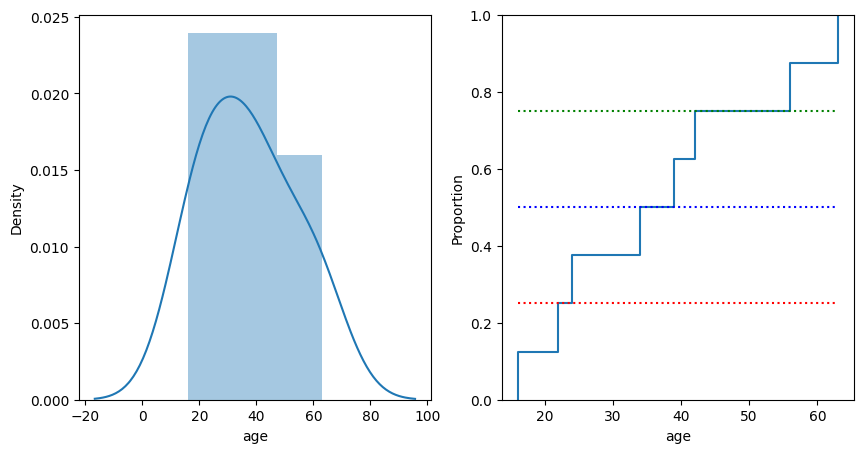

In [280]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=  (10,5))

sns.distplot(users_df.age , ax = ax1)
sns.ecdfplot(users_df.age, ax = ax2)
ax2.plot([users_df.age.min(),users_df.age.max()],[0.25,0.25], "r:" ,label = "0.25")
ax2.plot([users_df.age.min(),users_df.age.max()],[0.5,0.5], "b:", label = "0.5")
ax2.plot([users_df.age.min(),users_df.age.max()],[0.75,0.75], "g:" , label = "0.75")

In [281]:
ages_df = pd.get_dummies(users_df.user_age_group)

ages_df.columns = ["19세 이하","20대", "30대", "40대", "50대", "60대 이상"]
ages_df = ages_df.astype(int)
ages_df

,19세 이하,20대,30대,40대,50대,60대 이상
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,1,0
5,0,0,0,0,0,1
6,1,0,0,0,0,0
7,0,0,0,1,0,0


In [282]:
users_df = pd.concat([users_df, ages_df], axis=1)

users_df.drop("user_age_group", axis=1, inplace=True)
users_df.drop("age", axis=1, inplace=True)
users_df

,user_idx,user_id,user_mbti,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상
0,1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,ENFP,1,0,0,1,0,0,0,0
1,2,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,ISTJ,0,1,0,1,0,0,0,0
2,3,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,INFP,0,1,0,0,1,0,0,0
3,4,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,ESTJ,0,1,0,0,1,0,0,0
4,5,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,INTP,1,0,0,0,0,0,1,0
5,6,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,INFP,1,0,0,0,0,0,0,1
6,7,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,ENTP,1,0,1,0,0,0,0,0
7,8,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,ISFJ,1,0,0,0,0,1,0,0


##### field : MBTI

In [283]:
mbti_df = pd.get_dummies(users_df.user_mbti)
mbti_df = mbti_df.astype(int)
mbti_df

,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0
6,0,1,0,0,0,0,0
7,0,0,0,0,0,1,0


In [284]:
users_df = pd.concat([users_df,mbti_df], axis=1)
users_df.drop("user_mbti",axis=1, inplace=True)
users_df

,user_idx,user_id,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,2,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2,3,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
3,4,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,6,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
6,7,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
7,8,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


### concat X_fields

In [285]:
ratings_df.head()

,user_idx,regioncd_value,pla_r_rate
0,1,4,5.8
1,1,4,7.4
2,1,2,6.6
3,1,2,8.5
4,1,1,7.6


In [286]:
travels_df.head()

,contentscd,regioncd_value,1~2시간,1시간미만,2022_마을산책_봄,2022고메페스타,2023_관광10선_가을,2023_관광10선_봄,2~3시간,3시간이상,...,휴식/치유,휴식/힐링,휴양림,흐림,흑돼지,흑염소,흙,흡연구역,힐링,힐링여행
277,c1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
313,c1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,c1,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
359,c1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,c1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
users_df.head()

,user_idx,user_id,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,2,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2,3,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
3,4,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [288]:
ratings_df = ratings_df.merge(users_df, how="left")
ratings_df = ratings_df.merge(travels_df, how="left")
ratings_df.drop("user_id", inplace=True, axis=1)
ratings_df.drop("contentscd", inplace=True, axis=1)
ratings_df

,user_idx,regioncd_value,pla_r_rate,gender_0,gender_1,19세 이하,20대,30대,40대,50대,...,휴식/치유,휴식/힐링,휴양림,흐림,흑돼지,흑염소,흙,흡연구역,힐링,힐링여행
0,1,4,5.8,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,5.8,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,5.8,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,5.8,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,5.8,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,6,3,3.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25736,6,3,3.8,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
25737,6,3,3.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25738,6,3,3.8,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [289]:
# target
target = ratings_df["pla_r_rate"]
# ratings_df.drop("pla_r_rate", inplace=True, axis=1)

In [290]:
binary_target = target>= 4.0

In [291]:
object_columns = ratings_df.select_dtypes(include=['object']).columns
print(object_columns)

Index([], dtype='object')


## baseline : BinaryClassifier with normal DNN

In [292]:
from sklearn.model_selection import train_test_split

In [293]:
train_x, test_x, train_y, test_y = train_test_split(ratings_df, binary_target)

In [294]:
model = keras.models.Sequential([
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(1,activation = "sigmoid"),
])

In [295]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(0.001),
              metrics=[
                  keras.metrics.AUC(),
                  keras.metrics.BinaryAccuracy()
              ])

In [296]:
history = model.fit(train_x, train_y, epochs=5, batch_size=32,
                    validation_data=(test_x, test_y))

Epoch 1/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - auc_5: 0.9928 - binary_accuracy: 0.9844 - loss: 0.0392 - val_auc_5: 0.9996 - val_binary_accuracy: 0.9922 - val_loss: 0.0118
Epoch 2/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - auc_5: 0.9998 - binary_accuracy: 0.9945 - loss: 0.0103 - val_auc_5: 0.9988 - val_binary_accuracy: 0.9904 - val_loss: 0.0124
Epoch 3/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc_5: 0.9997 - binary_accuracy: 0.9934 - loss: 0.0105 - val_auc_5: 0.9988 - val_binary_accuracy: 0.9922 - val_loss: 0.0126
Epoch 4/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - auc_5: 0.9997 - binary_accuracy: 0.9948 - loss: 0.0116 - val_auc_5: 0.9988 - val_binary_accuracy: 0.9925 - val_loss: 0.0126
Epoch 5/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - auc_5: 0.9998 - binary_accuracy: 0.9951 - loss: 0.0101 - val_auc_5: 0.9987 - val_binary_accuracy: 0.9902 - val_loss: 0.0145


<Axes: >

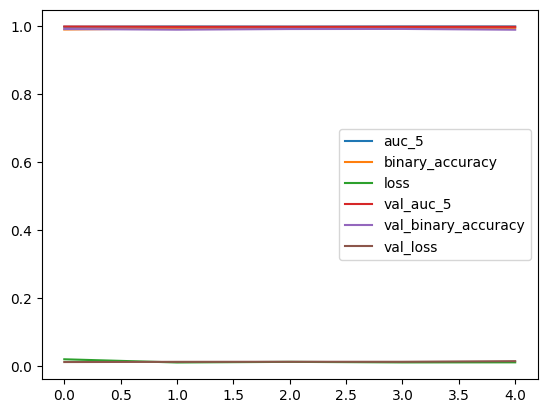

In [297]:
pd.DataFrame(history.history).plot()